# The influence of the intercept distribution on representation in the NEF

*Jan Gosmann*

## Abstract

This report empirically investigates the effect of a number of intercept distributions on the noise and distortion error of neural representations in the Neural Engineering Framework (NEF). A number of distributions can increase the representational accuracy compared to a uniform intercept distribution. While the optimal intercept distribution depends on a number of factors, a `CosineSimilarity(d+2)` distribution is shown to be a good default. In particular, it improves the scaling of the noise error for spiking neurons to $O(d^{3/4}/\sqrt{n})$ from $O(d/\sqrt{n})$ where $d$ is the number of dimensions and $n$ is the number of neurons. Furthermore, it is shows that by using `CosineSimilarity(d+2)` for intercepts and evaluation points, the accuracy of previous methods to optimize Semantic Pointer representations can be matched or exceeded without an expensive optimization step.

In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict
from functools import partial
import itertools
import re
import string

In [3]:
from joblib import Memory
import matplotlib.pyplot as plt
import nengo
import numpy as np
from psyrun import map_pspace, map_pspace_parallel, Param
import scipy.spatial
from scipy.special import gamma
from scipy.stats import linregress
import seaborn as sns

In [4]:
from cue.analysis.analysis import bootstrap_ci, bootstrap_diff_p
from cue.utils.plotting import row_height, save_tight_fig, single_fig_size, style, textwidth

In [5]:
memory = Memory(cachedir='.cache', verbose=0)

In [6]:
style()

In [7]:
def ci_l(x, func):
    return bootstrap_ci(x, func)[0]

def ci_u(x, func):
    return bootstrap_ci(x, func)[1]

statistic = lambda func: (func, partial(ci_l, func=func), partial(ci_u, func=func))

## Measuring noise and distortion

To analyze the effect of different intercept distributions, it is necessary to measure the noise and distortion error in the representation for different values in the representational space. It is not easy, to exhaustively quantify this in an arbitrary high-dimensional space. But we can make use of the fact that our representational space is usually isotropic. That is, our encoders and evaluation points have the same distribution along every possible direction. This allows us to cut through the hyper-ball with a one-dimensional line (intersecting the center) at which we take measurements of the error and this tells us the error along any choice of direction. Without loss of generality we can chose that line to align with the first dimension.

Each point on that line will be presented as stimulus to an ensemble for a duration of *adjust_duration* to reach the steady state and then measure the response for *sample_duration*. Summing those values gives the *measurement_duration*.

We define the total error as $E_{\mathrm{tot}} = \langle |\vec x - \hat{\vec x}| \rangle = \sqrt{E_{\mathrm{n}}^2 + E_{\mathrm{d}}^2}$ where $\vec x$ is the true value, $\hat{\vec x}$ the decoded value, $|\cdot|$ the L2 norm, and $\langle \cdot \rangle$ the average over time. The noise error is given by $E_{\mathrm{n}} = \langle |\hat{\vec{x}} - \langle \hat{\vec x} \rangle|\rangle$. The distortion error is given by $E_{\mathrm{d}} = |\vec x - \langle \hat{\vec x} \rangle|$.

In [8]:
class StimulusFunction(object):
    """Provides a stimulus on a line.
    
    Parameters
    ----------
    x : (n,) ndarray
        Coordinates on the line to define stimuli.
    d : int
        Dimensionality of the stimulus.
    measurement_duration : float
        Duration to present each stimulus for.
    """
    def __init__(self, x, d, measurement_duration):
        self.x = x
        self.measurement_duration = measurement_duration
        self._stimulus = np.zeros(d)
        
    def __call__(self, t):
        i = int(t // self.measurement_duration)
        if i < len(self.x):
            self._stimulus[0] = self.x[i]
        else:
            self._stimulus[0] = 0.
        return self._stimulus


@memory.cache
def measure_error(
        x, d, n, synapse=0.005, adjust_duration=None, sample_duration=None,
        solver=None, function=None, seed=None, **ens_kwargs):
    """Determine error measures for *d* dimensional representation with given parameters.
    
    Parameters
    ----------
    x : (n,) ndarray
        Coordinates of a 1d line cutting through the hyper-ball to sample error at.
    d : int
        Dimensionality of the representation.
    n : int
        Number of neurons in the ensemble.
    synapse : float or nengo.Synapse
        Synapse on the outgoing connection from the high-dimensional ensemble.
    adjust_duration : float, optional
        Duration to wait for steady state response. If `None`, 100 times *synapse* will be used.
    sample_duration : float, optional
        Duration to sample for.
    solver : nengo.Solver, optional
        Solver to determine decoders for the representation.
    seed : int, optional
        Network seed.
    ens_kwargs : dict
        Passed to the ensemble.
        
    Returns
    -------
    dict
        Dict where `'total'` is the total error,
        `'noise'` the noise error and `'distortion'` the distortion
        (all averages over *sample_duration*).
    """
    if adjust_duration is None:
        adjust_duration = 100. * synapse
    if sample_duration is None:
        sample_duration = 100. * synapse
    if function is None:
        function = lambda x: x
    if solver is None:
        solver = nengo.solvers.LstsqL2()
        
    measurement_duration = adjust_duration + sample_duration
    total_duration = len(x) * measurement_duration
           
    with nengo.Network(seed=seed) as model:
        ens = inp = nengo.Ensemble(n, d, **ens_kwargs)
        out = nengo.Node(size_in=len(function(np.zeros(d))))
        nengo.Connection(ens, out, solver=solver, function=function, synapse=None)
        stim_node = nengo.Node(StimulusFunction(x, d, measurement_duration))
        nengo.Connection(stim_node, inp, synapse=None)
        p = nengo.Probe(out, synapse=synapse)

    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(total_duration)

    t = sim.trange()
    distortion = np.empty_like(x)
    noise = np.empty_like(x)
    total = np.empty_like(x)
    for i in range(len(x)):
        s = np.logical_and(i * measurement_duration + adjust_duration < t, t <= (i + 1) * measurement_duration)
        y = np.mean(sim.data[p][s], axis=0)
        x_prime = np.zeros(d)
        x_prime[0] = x[i]
        distortion[i] = np.sqrt(np.sum(np.square(function(x_prime) - y)))
        noise[i] = np.mean(np.linalg.norm(sim.data[p][s] - y[None, :], axis=1))

        total[i] = np.mean(np.linalg.norm(sim.data[p][s] - function(x_prime)[None, :], axis=1))
        
    return {
        'total': total,
        'noise': noise,
        'distortion': distortion,
    }

We can estimate the mean error from the error on the line.

In [9]:
def integrate_ball_from_line(x, y, d):
    # When using np.linspace we have the left and right side end point,
    # thus interpolating points inbetween to avoid over estimation by
    # the additional point.
    dx = np.diff(x)
    dy = np.diff(y)
    dangle = 2. * np.pi**(d / 2.) / gamma(d / 2.)
    y_interp = y[:-1] + dy / 2.
    # To can a somewhat decent approximation of the integral in high dimensions we have
    # to take the mean of the radius term at multiple location because otherwise we will
    # easily under- or overestimate the value.
    radius_factor = np.mean(np.abs(x[:-1, None] + np.linspace(
        0., dx[0], endpoint=False)[None, :])**(d-1), axis=1)
    # Dividing by 2 because we are integrating from -1 to +1, not 0 to 1, thus doubling
    # the error.
    return np.sum(y_interp * dx * radius_factor) * dangle / 2.

def ball_volume(d, radius=1.):
    # https://en.wikipedia.org/wiki/Volume_of_an_n-ball
    return np.pi**(d / 2.) / gamma(d / 2. + 1.) * radius**d

def mean_error(x, y, d):
    return integrate_ball_from_line(x, y, d) / ball_volume(d)

In [10]:
def extend_df_with_error_means(x, df):
    for tp in ['total', 'noise', 'distortion']:
        df['mean_' + tp] = df.apply(lambda row: mean_error(x, row[tp], row['d']), axis=1)
    return x, df

In [11]:
def process_pspace(pspace, x=None):
    if x is None:
        x = np.linspace(-1., 1.)
    return x, pd.DataFrame(map_pspace(
        lambda **kwargs: measure_error(x, **{k: v for k, v in kwargs.items() if k != 'tag'}), pspace))

## Noise with neuron number and number of dimensions

To verify above code let us reproduce the result the noise goes down by $O(\sqrt{n})$ with n being the number of neurons.  For the number of dimensions we get an increase of the noise by a factor of $O(d)$ (see S4 of [1]).

[1]: Gosmann, Jan, and Chris Eliasmith. “Optimizing Semantic Pointer Representations for Symbol-Like Processing in Spiking Neural Networks.” PLoS ONE 11, no. 2 (February 22, 2016): e0149928. [doi:10.1371/journal.pone.0149928](http://dx.doi.org/10.1371/journal.pone.0149928).

In [12]:
pspace = Param(n=[50, 100, 200, 500, 1000, 2000]) * Param(d=[1, 16, 32, 64]) * Param(seed=np.arange(15))
x, df = extend_df_with_error_means(*process_pspace(pspace))

In [13]:
pspace = Param(n=2000, d=[1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64]) * Param(seed=np.arange(15))
x2, df2 = extend_df_with_error_means(*process_pspace(pspace))

In [14]:
df_stat = df.groupby(['d', 'n']).agg({'mean_' + k: statistic(np.mean) for k in ['total', 'noise', 'distortion']})
df2_stat = df2.groupby(['d', 'n']).agg({'mean_' + k: statistic(np.mean) for k in ['total', 'noise', 'distortion']})

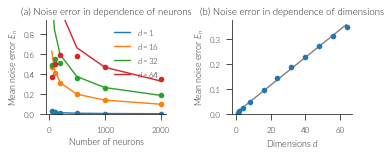

In [15]:
fig = plt.figure(figsize=(textwidth, row_height))

ax1 = fig.add_subplot(1, 2, 1)

for d, g in df_stat.groupby('d'):
    n = g.index.get_level_values('n')
    m = g['mean_noise', 'mean']
    l = m - g['mean_noise', 'ci_l']
    u = g['mean_noise', 'ci_u'] - m
    ax1.errorbar(n, m, yerr=(l, u), fmt='o', label=None)
    
ax1.set_prop_cycle(None)
for d, g in df_stat.groupby('d'):
    ax1.plot(n, g.loc[d, 1000]['mean_noise', 'mean'] * np.sqrt(1000. / n), label='$d = {}$'.format(d))
    
ax1.set_ylim(bottom=0., top=1.6 * df_stat['mean_noise', 'mean'].max())
ax1.legend()
ax1.set_title("(a) Noise error in dependence of neurons")
ax1.set_xlabel("Number of neurons")
ax1.set_ylabel("Mean noise error $E_{\mathrm{n}}$")

ax2 = fig.add_subplot(1, 2, 2)
d = df2_stat.index.get_level_values('d')
m = df2_stat['mean_noise', 'mean']
l = m - df2_stat['mean_noise', 'ci_l']
u = df2_stat['mean_noise', 'ci_u'] - m
ax2.errorbar(d, m, yerr=(l, u), fmt='o')
slope, intercept, _, _, _ = linregress(d, m)
ax2.plot(d, d * slope + intercept, c='gray')

ax2.set_ylim(bottom=0.)
ax2.set_title("(b) Noise error in dependence of dimensions")
ax2.set_xlabel("Dimensions $d$")
ax2.set_ylabel("Mean noise error $E_{\mathrm{n}}$")
    
sns.despine(fig)
fig.tight_layout()

In [16]:
save_tight_fig(fig, '../../../phd-thesis/figures/noise-error.pdf')

## Noise and distortion depending on represented value

Now let us look more closely how different parts of the representational space are affected by noise and distortion. We will scale the neuron number by the number of dimensions which is the standard scaling in the Nengo SPA implementation. This offsets some of the increase of noise caused by the increase of dimensionality, but not all of it. Another reason for not using the quadratic scaling is that the ensemble size for higher dimensionalities grows too quickly to be reasonable to simulate.

In [17]:
ds = np.array([1, 4, 16, 64])
pspace = Param(d=ds, n=50 * ds) * Param(seed=np.arange(15))
x, df = process_pspace(pspace)

In [18]:
def plot_ball_cut(data, y, hue, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    col_cycle = iter(sns.color_palette('husl', n_colors=len(data[hue].unique())))
    for (d, g), color in zip(data.groupby(hue, sort=False), col_cycle):
        hue_data = np.array([g2[y].values[0] for seed, g2 in g.groupby('seed')])
        ci = np.apply_along_axis(partial(bootstrap_ci, func=np.mean), 0, hue_data)
        ax.fill_between(x, ci[0], ci[1], color=color, alpha=0.5)
        ax.plot(x, np.mean(hue_data, axis=0), color=color, label="${} = {}$".format(hue, d), **kwargs)
        
def make_error_plot(data, hue, legend_labels=None, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(textwidth, row_height),)
    
    ax = None
    for i, tp in enumerate(['noise', 'distortion', 'total']):
        with sns.axes_style('whitegrid', rc={'axes.linewidth': 0.5, 'lines.linewidth': 0.25}):
            ax = fig.add_subplot(1, 3, i + 1, sharey=ax, sharex=ax)
        plot_ball_cut(data, tp, hue, ax=ax)
        if i > 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax.set_ylabel(r"Mean error $\langle E \rangle$")

        ax.set_xlim(-1., 1.)
        ax.set_ylim(bottom=0.)
        ax.set_title("({}) {} error".format(string.ascii_lowercase[i], tp.capitalize()))
        ax.set_xlabel("$x$")
        
    handles, labels = ax.get_legend_handles_labels()
    if legend_labels is not None:
        labels = legend_labels
    fig.legend(handles, labels,
               loc='upper center', bbox_to_anchor=(0.5, 0.25),
               bbox_transform=fig.transFigure, ncol=7)
    sns.despine(fig, right=False)
    fig.tight_layout(rect=(0., 0.2, 1., 1.))
    return fig

In [19]:
def error_statistics(x, df, hue):
    x, df = extend_df_with_error_means(x, df)
    comparisons = list(itertools.combinations(df[hue].unique(), 2))
    stats = defaultdict(list)
    for a, b in comparisons:
        d1 = df[df[hue] == a]
        d2 = df[df[hue] == b]
        for k in ['total', 'distortion', 'noise']:
            stats[(k, 'diff')].append(d2['mean_' + k].mean() - d1['mean_' + k].mean())
            stats[(k, 'p')].append(bootstrap_diff_p(d1['mean_' + k], d2['mean_' + k]))
    return pd.DataFrame(stats, index=comparisons)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


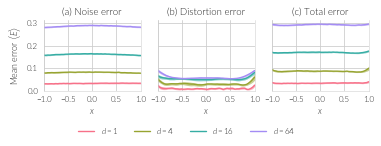

In [20]:
fig = make_error_plot(df, 'd');

In [21]:
save_tight_fig(fig, '../../../phd-thesis/figures/error-linecut.pdf')

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


This plot shows the mean error for each dimensionality averaged over five trials with the shaded regions indicating the minimum and maximum values.

We observe that the noise is pretty constant, though for higher dimensionalities it might decrease toward the surface of the n-ball (left and right edge of the plot). The distortion is interesting, it increases towards the hyperball surface and more so the higher the dimensionality.

The distortion towards the surface can be explained by the following visualization.

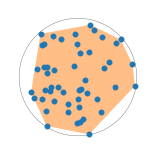

In [22]:
eval_points = nengo.dists.UniformHypersphere().sample(50, 2, np.random.RandomState(42))
hull = scipy.spatial.ConvexHull(eval_points)

fig = plt.figure(figsize=(row_height, row_height))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.scatter(eval_points[:, 0], eval_points[:, 1], color=sns.color_palette()[0], zorder=2)
ax.add_artist(plt.Polygon(eval_points[hull.vertices], ec='none', fc=sns.color_palette()[1], alpha=0.5, zorder=1))
ax.add_artist(plt.Circle((0, 0), radius=1, fc='none', ec='black'))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

sns.despine(fig, bottom=True, left=True)
fig.tight_layout()

In [23]:
save_tight_fig(fig, '../../../phd-thesis/figures/circle-covering.pdf')



Here we sample 50 evaluation points uniformly in the 2d sphere as it is done in Nengo by default. But because all points are sampled from within the sphere, the convex hull of those points does not cover all of the sphere. These regions outside of the convex hull, but inside the hypersphere will not be considered in the decoder optimization. This is not extremely bad because the smoothness of the neuron tuning curves allows for extrapolation outside of the convex hull, but it explains the increased distortion towards the hypersphere surface. Note that this problem will get more pronounced with more dimensions, because the volume of an n-dimensional ball approaches 0 for $n \rightarrow \infty$.

To show that the distortion is indeed caused by the incomplete covering with evaluation points, we slightly increase the radius from which the evaluation points will be picked.

In [24]:
class Scale(nengo.dists.Distribution):
    def __init__(self, factor, dist):
        super(Scale, self).__init__()
        self.factor = factor
        self.dist = dist
        
    def sample(self, n, d=None, rng=None):
        return self.factor * self.dist.sample(n, d, rng=rng)
    
    def __repr__(self):
        return 'Scale({!r}, {!r})'.format(self.factor, self.dist)
    
    def __hash__(self):
        return hash((self.factor, self.dist))
    
    def __eq__(self, other):
        return isinstance(other, Scale) and self.factor == other.factor and self.dist == other.dist

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


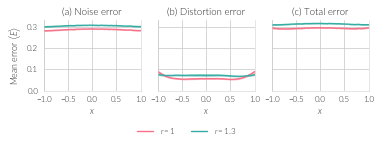

In [25]:
d = 64
pspace = Param(d=d, n=50 * d, eval_points=[
    nengo.dists.UniformHypersphere(),
    Scale(1.3, nengo.dists.UniformHypersphere()),
]) * Param(seed=np.arange(15))
x, df = process_pspace(pspace)
fig = make_error_plot(df, 'eval_points', ["$r = 1$", "$r = 1.3$"]);

In [26]:
save_tight_fig(fig, '../../../phd-thesis/figures/error-radius-scale.pdf')

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


In [27]:
error_statistics(x, df, 'eval_points')

distortion          noise  \
                                                         diff    p      diff   
(UniformHypersphere(), Scale(1.3, UniformHypers...  -0.011335  0.0  0.018953   

                                                            total       
                                                      p      diff    p  
(UniformHypersphere(), Scale(1.3, UniformHypers...  0.0  0.015165  0.0

We see that this makes the distortion flatter, but it also increases the noise and mean distortion because we are effectively scaling the ensemble radius.

## Activity distribution

In [28]:
d = 64
n = 50 * 64

with nengo.Network(seed=42) as model:
    ens = nengo.Ensemble(n, d)

with nengo.Simulator(model) as sim:
    pass

act = np.mean(nengo.builder.ensemble.get_activities(sim.data[ens], ens, sim.data[ens].eval_points) > 0., axis=0)

Building finished in 0:00:01.                                                                                                                                                                                                                


/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


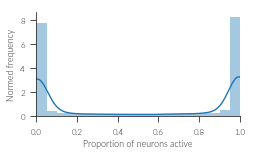

In [29]:
fig = plt.figure(figsize=single_fig_size)
ax = fig.add_subplot(1, 1, 1)
sns.distplot(act, norm_hist=True, bins=20, ax=ax, kde_kws={'bw': 0.05})
ax.set_xlim(0., 1.)
ax.set_xlabel("Proportion of neurons active")
ax.set_ylabel("Normed frequency")
sns.despine(fig)
fig.tight_layout()

In [30]:
save_tight_fig(fig, '../../../phd-thesis/figures/act-proportion.pdf')

In [31]:
@memory.cache
def inactive_fraction(d, seed=42, n_per_d=50, **kwargs):
    n = n_per_d * d
    
    with nengo.Network(seed=seed) as model:
        ens = nengo.Ensemble(n, d, n_eval_points=10000, **kwargs)

    with nengo.Simulator(model, progress_bar=False) as sim:
        pass

    return np.sum(np.max(nengo.builder.ensemble.get_activities(
        sim.data[ens], ens, sim.data[ens].eval_points), axis=0) <= 0) / float(n)

@memory.cache
def inactive_fraction_mean(ds, n_trials=30, n_per_d=50, **kwargs):
    raw = [[inactive_fraction(d, seed=i, **kwargs) for i in range(n_trials)] for d in ds]
    mean = [np.mean(x) for x in raw]
    ci = np.array([bootstrap_ci(x, np.mean) for x in raw]).T
    return mean, ci

In [32]:
d = 64
n = 50 * 64

with nengo.Network(seed=42) as model:
    ens = nengo.Ensemble(n, d, intercepts=nengo.dists.CosineSimilarity(d + 2))

with nengo.Simulator(model) as sim:
    pass

act = np.mean(nengo.builder.ensemble.get_activities(sim.data[ens], ens, sim.data[ens].eval_points) > 0., axis=0)

Building finished in 0:00:01.                                                                                                                                                                                                                


/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


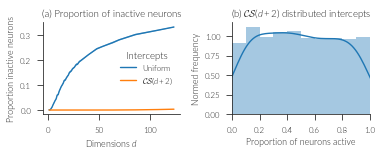

In [33]:
ds = np.concatenate((np.array(np.arange(1, 33)), [40, 48, 54, 64, 70, 86, 108, 124]))

fig = plt.figure(figsize=(textwidth, row_height))
ax1 = fig.add_subplot(1, 2, 1)

mean, ci = inactive_fraction_mean(ds)
ax1.plot(ds, mean, label="Uniform")
ax1.fill_between(ds, ci[0], ci[1], alpha=0.5)

mean, ci = inactive_fraction_mean(ds, intercepts=nengo.dists.CosineSimilarity(d + 2))
ax1.plot(ds, mean, label=r"$\mathcal{CS}(d + 2)$")
ax1.fill_between(ds, ci[0], ci[1], alpha=0.5)

ax1.legend(title="Intercepts")
ax1.set_title("(a) Proportion of inactive neurons")
ax1.set_xlabel("Dimensions $d$")
ax1.set_ylabel("Proportion inactive neurons")


ax2 = fig.add_subplot(1, 2, 2)
sns.distplot(act, norm_hist=True, bins=10, ax=ax2, kde_kws={'bw': 0.1})
ax2.set_xlim(0., 1.)
ax2.set_title(r"(b) $\mathcal{CS}(d + 2)$ distributed intercepts")
ax2.set_xlabel("Proportion of neurons active")
ax2.set_ylabel("Normed frequency")

sns.despine(fig)
fig.tight_layout()

In [34]:
save_tight_fig(fig, '../../../phd-thesis/figures/act-cs.pdf')

## Cosine similarity distribution

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/dists.py:450: RuntimeWarning: divide by zero encountered in power
  (1 - x * x) ** (self.n / 2.0 - 1))


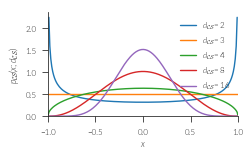

In [35]:
x = np.linspace(-1., 1., 200)

fig = plt.figure(figsize=single_fig_size)
ax = fig.add_subplot(1, 1, 1)
for d in [2, 3, 4, 8, 16]:
    ax.plot(x, nengo.dists.CosineSimilarity(d).pdf(x), label=r"$d_{{\mathcal{{CS}}}} = {}$".format(d))

ax.set_xlim(-1., 1.)
ax.set_ylim(bottom=0.)
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel(r"$p_{\mathcal{CS}}(x; d_{\mathcal{CS}})$")
    
sns.despine(fig)
fig.tight_layout()

In [36]:
save_tight_fig(fig, '../../../phd-thesis/figures/cosine-sim.pdf')

## Non-uniform intercept distributions

Let us now turn to the main focus of this report: the effect of non-uniform intercept distributions. We will first look at ensembles and connections with default parameters to obtain some initial results for a large number of distributions. Later we will focus on a subset of these distributions to investigate their interplay with non-default parameters.

### Default parameters (synaptic time constant 0.005s, regularization = 0.1)

In [37]:
d = 64

pspace = Param(
    d=d, n=50 * d, synapse=[0.005, 0.1]) * Param(
        intercepts=[
            nengo.dists.Uniform(-1., 1.),
            nengo.dists.CosineSimilarity(d + 2)]
) * Param(seed=np.arange(15))

x, df = process_pspace(pspace)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


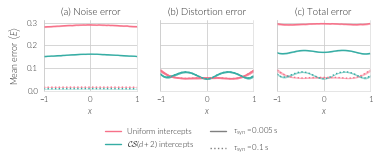

In [38]:
fig = make_error_plot(
    df[df['synapse'] == 0.005], 'intercepts');

for i, k in enumerate(['noise', 'distortion', 'total']):
    plot_ball_cut(df[df['synapse'] == 0.1], k, 'intercepts', ax=fig.axes[i], linestyle=':')
    
fig.legends[0].remove()
handles, labels = fig.axes[0].get_legend_handles_labels()
handles = handles[:2] + [
    plt.Line2D((0, 1), (0, 0), color='gray'),
    plt.Line2D((0, 1), (0, 0), color='gray', linestyle=':')]
labels = ["Uniform intercepts", r"$\mathcal{CS}(d+2)$ intercepts",
          r"$\tau_{\mathrm{syn}} = 0.005\,\mathrm{s}$", r"$\tau_{\mathrm{syn}} = 0.1\,\mathrm{s}$"]
fig.legend(
    handles, labels,
    loc='upper center', bbox_to_anchor=(0.5, 0.25),
    bbox_transform=fig.transFigure, ncol=2)

fig.tight_layout(rect=(0., 0.2, 1., 1.))

In [39]:
save_tight_fig(fig, '../../../phd-thesis/figures/error-cs-intercepts.pdf')

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


In [40]:
error_statistics(x, df[df['synapse'] == 0.005].copy(), 'intercepts')

distortion          noise  \
                                                         diff    p      diff   
(Uniform(low=-1.0, high=1.0), CosineSimilarity(...  -0.019986  0.0 -0.131299   

                                                            total       
                                                      p      diff    p  
(Uniform(low=-1.0, high=1.0), CosineSimilarity(...  0.0 -0.130364  0.0

In [41]:
error_statistics(x, df[df['synapse'] == 0.1].copy(), 'intercepts')

distortion          noise  \
                                                         diff    p      diff   
(Uniform(low=-1.0, high=1.0), CosineSimilarity(...  -0.019954  0.0 -0.006623   

                                                            total       
                                                      p      diff    p  
(Uniform(low=-1.0, high=1.0), CosineSimilarity(...  0.0 -0.020718  0.0

### Solver regularization

In [42]:
d = 64

pspace = Param(
    d=d, n=50 * d, intercepts=nengo.dists.CosineSimilarity(d + 2),
    solver=[
        nengo.solvers.LstsqL2(reg=0.2), nengo.solvers.LstsqL2(reg=0.1), nengo.solvers.LstsqL2(reg=0.05)],
) * Param(seed=np.arange(15))

x, df = process_pspace(pspace)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


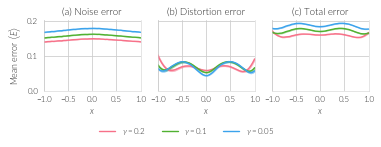

In [43]:
fig = make_error_plot(df, 'solver', [r"$\gamma = {}$".format(reg) for reg in (0.2, 0.1, .05)]);

In [44]:
save_tight_fig(fig, '../../../phd-thesis/figures/error-cs-intercepts-reg.pdf')

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


In [45]:
error_statistics(x, df, 'solver')

distortion          noise  \
                                                         diff    p      diff   
(LstsqL2(reg=0.2, solver=Cholesky(transpose=Non...  -0.023504  0.0  0.011590   
(LstsqL2(reg=0.2, solver=Cholesky(transpose=Non...  -0.031544  0.0  0.027463   
(LstsqL2(reg=0.1, solver=Cholesky(transpose=Non...  -0.008041  0.0  0.015873   

                                                            total          
                                                      p      diff       p  
(LstsqL2(reg=0.2, solver=Cholesky(transpose=Non...  0.0 -0.000878  0.3818  
(LstsqL2(reg=0.2, solver=Cholesky(transpose=Non...  0.0  0.010972  0.0000  
(LstsqL2(reg=0.1, solver=Cholesky(transpose=Non...  0.0  0.011850  0.0000

## Noise scaling revisited

With the non-linear intercept distributions the scaling of the noise with dimensions is reduced to $O(d^{3/4})$ instead of $O(d)$.

In [46]:
ds = [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64]
pspace = Param(
    n=2000, d=ds,
    intercepts=[nengo.dists.CosineSimilarity(d + 2) for d in ds]) * Param(seed=np.arange(15))
x, df = extend_df_with_error_means(*process_pspace(pspace))

In [47]:
df_stat = df.groupby(['d', 'n']).agg({'mean_' + k: statistic(np.mean) for k in ['total', 'noise', 'distortion']})

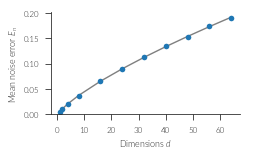

In [48]:
fig = plt.figure(figsize=single_fig_size)
ax = fig.add_subplot(1, 1, 1)
d = df_stat.index.get_level_values('d')
m = df_stat['mean_noise', 'mean']
l = m - df_stat['mean_noise', 'ci_l']
u = df_stat['mean_noise', 'ci_u'] - m
ax.errorbar(d, m, yerr=(l, u), fmt='o')
slope, intercept, _, _, _ = linregress(d**0.75, m)
ax.plot(d, d**.75 * slope + intercept, c='gray')

ax.set_ylim(bottom=0.)
ax.set_xlabel("Dimensions $d$")
ax.set_ylabel("Mean noise error $E_{\mathrm{n}}$")

sns.despine(fig)
fig.tight_layout()

In [49]:
save_tight_fig(fig, '../../../phd-thesis/figures/cs-error-scaling.pdf')

## Further experiments for appendix

In [50]:
def pairwise_products(x):
    return x[::2] * x[1::2]

In [51]:
d = 64
default_solver = nengo.solvers.LstsqL2(reg=0.1)
pspace = (
    Param(
        n=np.array([10, 25]) * d,
        synapse=0.005,
        neuron_type=nengo.LIF(),
        solver=default_solver,
        function=None) +
    Param(
        n=50 * d,
        synapse=[0.1],
        neuron_type=nengo.LIF(),
        solver=default_solver,
        function=None) +
    (Param(solver=[default_solver, nengo.solvers.LstsqL2(reg=0.01)]) * Param(
        n=50 * d,
        synapse=0.005,
        function=None,
        neuron_type=[nengo.LIF(), nengo.AdaptiveLIF(), nengo.RectifiedLinear(), nengo.LIFRate()])) +
    (Param(solver=[nengo.solvers.LstsqL2(reg=0.2), nengo.solvers.LstsqL2(reg=0.005)]) * Param(
        n=50 * d,
        synapse=0.005,
        function=None,
        neuron_type=nengo.LIF())) +
    Param( 
        n=50 * d,
        synapse=0.005,
        neuron_type=nengo.LIF(),
        solver=default_solver,
        function=[np.square, pairwise_products])
) * Param(d=d, intercepts=[nengo.dists.Uniform(-1., 1.), nengo.dists.CosineSimilarity(d + 2)])
ds = [1, 2, 4, 8]
pspace += Param(
    n=[50 * d for d in ds],
    d=ds,
    synapse=0.005,
    neuron_type=nengo.LIF(),
    solver=default_solver,
    function=None,
    intercepts=[nengo.dists.CosineSimilarity(d + 2) for d in ds]
) + Param(
    n=[50 * d for d in ds],
    d=ds,
    synapse=0.005,
    neuron_type=nengo.LIF(),
    solver=default_solver,
    function=None,
    intercepts=nengo.dists.Uniform(-1., 1.)
)
pspace *= Param(seed=np.arange(15))

In [52]:
x, df = extend_df_with_error_means(*process_pspace(pspace))

In [53]:
df['function'] = df['function'].apply(lambda x: {
    'square': r'$\vc x^2$',
    'pairwise_products': r'$x_{2i-2} x_{2i - 1}$'}[x.__name__] if x is not None else r'$\vc x$')

In [54]:
def improvement(df, hue1, hue2):
    hues = df['intercepts'].apply(lambda x: x.__class__.__name__)
    assert hues.isin((hue1, hue2)).all(), hues
    d1 = df[hues == hue1]
    d2 = df[hues == hue2]
    fns = {'diff': lambda a, b: a.mean() - b.mean(), 'p': bootstrap_diff_p}
    return pd.DataFrame(
        {k: [{fn: fns[fn](d1[k], d2[k]) for fn in fns.keys()}] for k in ['mean_total', 'mean_distortion', 'mean_noise']})

In [55]:
df_summary = df.groupby(['d', 'n', 'neuron_type', 'solver', 'synapse', 'function'], sort=False).apply(
    improvement, hue1='CosineSimilarity', hue2='Uniform')

In [56]:
df_summary.reset_index(inplace=True)
del df_summary['level_6']
df_summary['neuron_type'] = df_summary['neuron_type'].apply(lambda x: re.sub(
    '([a-z])([A-Z])', r'\1 \2', re.sub(
        '(.)([A-Z])([a-z])', r'\1 \2\3', x.__class__.__name__)))
df_summary['reg'] = df_summary['solver'].apply(lambda x: x.reg)
del df_summary['solver']
df_summary['n'] //= df_summary['d']

In [57]:
title = 'Change in'
df_summary.columns = [
    r'$\dims$', '$n / \dims$', 'Neuron type', r'$\syntau / \si{\second}$', 'Function',
    r'$\langle\errdist\rangle$', r'$\langle\errnoise\rangle$', r'$\langle\errtotal\rangle$',
    r'$\lambda$']

In [58]:
df_summary.set_index(
    [r'$\dims$', '$n / \dims$', r'$\syntau / \si{\second}$', 'Function', r'$\lambda$', 'Neuron type'], inplace=True)
df_summary.sort_index(inplace=True)
df_summary

$\langle\errdist\rangle$  \
$\dims$ $n / \dims$ $\syntau / \si{\second}$ Function              $\lambda$ Neuron type                                                       
1       50          0.005                    $\vc x$               0.100     LIF               {'diff': 1.2849080544736352e-05, 'p': 0.9858}   
2       50          0.005                    $\vc x$               0.100     LIF                {'diff': 0.0006935373487160466, 'p': 0.5986}   
4       50          0.005                    $\vc x$               0.100     LIF                {'diff': -0.002040085331075192, 'p': 0.3642}   
8       50          0.005                    $\vc x$               0.100     LIF                {'diff': 0.0036561681879286392, 'p': 0.0874}   
64      10          0.005                    $\vc x$               0.100     LIF                    {'diff': -0.12385726519109116, 'p': 0.0}   
        25          0.005                    $\vc x$               0.100     LIF                    {'diff': -0.04380034323030774, 'p': 0.0}   
        50          0.005                    $\vc x$               0.005     LIF                    {'diff': 0.034684333550832655, 'p': 0.0}   
                                                                   0.010     Adaptive LIF             {'diff': 0.0821060272370703, 'p': 0.0}   
                                                                             LIF                    {'diff': 0.026205643385408477, 'p': 0.0}   
                                                                             LIF Rate               {'diff': 0.026216644979428466, 'p': 0.0}   
                                                                             Rectified Linear        {'diff': 0.03065106265473031, 'p': 0.0}   
                                                                   0.100     Adaptive LIF            {'diff': 0.03113217839300403, 'p': 0.0}   
                                                                             LIF                    {'diff': -0.01998629808658868, 'p': 0.0}   
                                                                             LIF Rate              {'diff': -0.019953903694741773, 'p': 0.0}   
                                                                             Rectified Linear   {'diff': 0.0021980363520863327, 'p': 0.2056}   
                                                                   0.200     LIF                     {'diff': -0.0872786554326745, 'p': 0.0}   
                                             $\vc x^2$             0.100     LIF                    {'diff': -0.10299033323251117, 'p': 0.0}   
                                             $x_{2i-2} x_{2i - 1}$ 0.100     LIF                    {'diff': 0.008360279430439767, 'p': 0.0}   
                    0.100                    $\vc x$               0.100     LIF                   {'diff': -0.019953778698958965, 'p': 0.0}   

                                                                                                                   $\langle\errnoise\rangle$  \
$\dims$ $n / \dims$ $\syntau / \si{\second}$ Function              $\lambda$ Neuron type                                                       
1       50          0.005                    $\vc x$               0.100     LIF                {'diff': 0.0009289477152641251, 'p': 0.2744}   
2       50          0.005                    $\vc x$               0.100     LIF                   {'diff': -0.005011356652797429, 'p': 0.0}   
4       50          0.005                    $\vc x$               0.100     LIF                   {'diff': -0.013890338543531083, 'p': 0.0}   
8       50          0.005                    $\vc x$               0.100     LIF                    {'diff': -0.03181686125505534, 'p': 0.0}   
64      10          0.005                    $\vc x$               0.100     LIF                    {'diff': -0.21313656378019652, 'p': 0.0}   
        25          0.005                    $\vc x$               0.100     LIF   

In [59]:
df_summary.columns = pd.MultiIndex.from_tuples([('Change in', c) for c in df_summary.columns])

In [60]:
def formatter(x):
    diff = x['diff']
    p = x['p']
    if diff > 0:
        fmt = r'\textbf{{\num{{{num}}}}}'
    else:
        fmt = r'\num{{{num}}}'
    if p < 0.0001:
        sig = '****'
    elif p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = ''
    return '{num}'.format(num=diff) + sig

In [61]:
def int_col(width):
    return 'S[table-number-alignment=right,table-figures-integer={},table-figures-decimal=0]'.format(width)

In [62]:
df_summary.to_latex(
    '../../../phd-thesis/tables/hdrep.tex',
    formatters=[formatter] * 3,
    escape=False,
    multicolumn_format='c',
    column_format= (
        int_col(2) + 
        int_col(4) +
        'S[table-figures-decimal=3]lS[table-figures-decimal=2]l' +
        3 * ('S[' + ','.join((
            'table-space-text-post={****}',
            'round-precision=4',
            'round-mode=places',
            'scientific-notation=fixed',
            'fixed-exponent=0',
            'negative-color=BrickRed')) + ']')))

# spa-opt

The methods presented in [1] (referred to as “spa-opt”) adjust the radius to decrease the error in high-dimensional representations. The radius is essentially scaling the intercepts and the distance of the evaluation points from the coordinate origin. Thus, the cosine similarity and subvector length distribution have a similar effect (if the evaluation points are adjusted accordingly) to a radius scaling because intercepts will be more likely to be close to the origin for higher dimensions. But it is more a soft radius adjustment (because there is still a small chance for large intercepts) instead of a hard cut off at the radius. It is worth investigating how these two ways of radius adjustment compare.

For that we will use the benchmarks from [1] (but with less trials). Note that this only look at unit length vectors, but not any vectors within in hyperball.

[1]: Gosmann, Jan, and Chris Eliasmith. “Optimizing Semantic Pointer Representations for Symbol-Like Processing in Spiking Neural Networks.” PLoS ONE 11, no. 2 (February 22, 2016): e0149928. [doi:10.1371/journal.pone.0149928](http://dx.doi.org/10.1371/journal.pone.0149928).

In [63]:
import functools
from scipy.special import beta, betainc

The signal generator is used to generate the test input.

In [64]:
class SignalGenerator(nengo.Process):
    def __init__(self, duration, high=5.):
        super(SignalGenerator, self).__init__()
        self._whitenoise = nengo.processes.WhiteSignal(duration, high=high)

    def make_step(self, size_in, size_out, dt, rng=np.random):
        return functools.partial(
            self.sample,
            sample_whitenoise=self._whitenoise.make_step(size_in, size_out, dt, rng))

    @staticmethod
    def sample(t, sample_whitenoise):
        sampled = sample_whitenoise(t)
        return sampled / np.linalg.norm(sampled)

The following provides the spa-opt implementation from [1].

In [65]:
def get_distortion(Simulator, ens, conn_kwargs=None, seed=None):
    if conn_kwargs is None:
        conn_kwargs = {}

    with nengo.Network(seed=seed, add_to_container=False) as m:
        ens_copy = ens.copy()
        ens_copy.radius = 1.
        conn = nengo.Connection(
            ens_copy,
            nengo.Ensemble(1, ens.dimensions, neuron_type=nengo.Direct()),
            **conn_kwargs)

    with Simulator(m) as sim:
        pass
    return np.mean(np.square(sim.model.params[conn].solver_info['rmses']))

def find_optimal_radius(distortion, sp_dimensions, sp_subdimensions=1):
    """Determines the optimal radius for ensembles when splitting up a
    semantic pointer (unit vector) into subvectors.
    Requires Scipy.
    Parameters
    ----------
    distortion : float
        Estimate of distortion for a radius of 1 to base optimization on.
    sp_dimensions : int
        Dimensionality of the complete semantic pointer/unit vector.
    sp_subdimensions : int, optional
        Dimensionality of the subvectors represented by the ensembles.
    Returns
    -------
    float
        Optimal radius for the representing ensembles.
    """
    res = scipy.optimize.minimize(
        lambda x: sp_subvector_error(
            x, distortion, sp_dimensions, sp_subdimensions),
        0.1, bounds=[(0., 1.)], method='L-BFGS-B')
    return np.asscalar(res.x)


def sp_subvector_error(radius, distortion, sp_dimensions, sp_subdimensions=1):
    """Estimate of representational error of a subvector of a semantic
    pointer (unit vector).
    Requires Scipy.
    Paramaters
    ----------
    radius : float or ndarray
        Radius of the representing ensemble.
    distortion : float
        Estimate of distortion for a radius of 1 to base optimization on.
    sp_dimensions : int
        Dimensionality of the complete semantic pointer/unit vector.
    sp_subdimensions : int, optional
        Dimensionality of the subvector represented by some ensemble.
    Returns
    -------
    Error estimates for representing a subvector with `subdimensions`
    dimensions of a `dimensions` dimensional unit vector with an ensemble
    initialized with of `radius`.
    """
    dist = nengo.dists.SubvectorLength(sp_dimensions, sp_subdimensions)
    in_range = _sp_subvector_error_in_range(radius, distortion,
        sp_subdimensions)
    out_of_range = _sp_subvector_error_out_of_range(
        radius, sp_dimensions, sp_subdimensions)
    return dist.cdf(radius) * in_range + (
        1.0 - dist.cdf(radius)) * out_of_range


def _sp_subvector_error_in_range(radius, distortion, subdimensions):
    return radius * radius * subdimensions * distortion


def _sp_subvector_error_out_of_range(radius, dimensions, subdimensions):
    dist = nengo.dists.SubvectorLength(dimensions, subdimensions)
    sq_r = radius * radius

    normalization = 1.0 - dist.cdf(radius)
    b = (dimensions - subdimensions) / 2.0
    aligned_integral = beta(subdimensions / 2.0 + 1.0, b) * (1.0 - betainc(
        subdimensions / 2.0 + 1.0, b, sq_r))
    cross_integral = beta((subdimensions + 1) / 2.0, b) * (1.0 - betainc(
        (subdimensions + 1) / 2.0, b, sq_r))

    numerator = (sq_r * normalization + (
        aligned_integral - 2.0 * radius * cross_integral) / beta(
        subdimensions / 2.0, b))
    with np.errstate(invalid='ignore'):
        return np.where(
            numerator > np.MachAr().eps,
            numerator / normalization, np.zeros_like(normalization))
    
class UnitEA(nengo.networks.EnsembleArray):
    def __init__(self, n_neurons, dimensions, n_ensembles, ens_dimensions=1,
                 label=None, radius=1.0, **ens_kwargs):
        if dimensions % n_ensembles != 0:
            raise ValueError(
                "'dimensions' has to be divisible by 'n_ensembles'.")

        if n_ensembles > 1:
            distortion = get_distortion(
                nengo.Simulator, nengo.Ensemble(
                    n_neurons * (dimensions // n_ensembles), dimensions // n_ensembles,
                    add_to_container=False, **ens_kwargs))
            opt_r = find_optimal_radius(distortion, dimensions, dimensions // n_ensembles)
            scaled_r = radius * opt_r
        else:
            scaled_r = 1.

        super(UnitEA, self).__init__(
            n_neurons * ens_dimensions, n_ensembles, ens_dimensions, label=label,
            radius=scaled_r, **ens_kwargs)

Now follows the benchmarking function.

In [66]:
@memory.cache
def get_repr_error(n_neurons, d, mode, seed, scale=1., sd=1):
    print(mode, sd, seed)
    seed = int(seed)
    n_neurons = int(n_neurons)
    d = int(d)
    sd = int(sd)
    duration = 5.

    rng = np.random.RandomState(seed)

    model = nengo.Network(seed=seed+1)
    with model:
        in_a = nengo.Node(SignalGenerator(duration), size_out=d)
        
        with nengo.Config(nengo.Ensemble, nengo.Connection) as cfg:
            if mode == 'default':
                repr_ = nengo.networks.EnsembleArray(n_neurons * sd, d // sd, sd)
            elif mode == 'spaopt':
                repr_ = UnitEA(n_neurons, d, d // sd, sd)
            elif mode == 'cosine':
                repr_ = nengo.networks.EnsembleArray(n_neurons * sd, d // sd, sd,
                                                     eval_points=nengo.dists.CosineSimilarity(d + 2),
                                                     intercepts=nengo.dists.CosineSimilarity(d + 2))
            else:
                raise ValueError("Invalid mode %r." % mode)
        result = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
        nengo.Connection(in_a, repr_.input, transform=scale)
        nengo.Connection(repr_.output, result)

        with nengo.Network() as net:
            net.config[nengo.Ensemble].neuron_type = nengo.Direct()
            d_repr = nengo.networks.EnsembleArray(1, d)
            d_result = nengo.Ensemble(1, d)
        nengo.Connection(in_a, d_repr.input, transform=scale)
        nengo.Connection(d_repr.output, d_result)
        
        probe = nengo.Probe(result, synapse=None)
        d_probe = nengo.Probe(d_result, synapse=None)

    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(duration)

    return {
        't': sim.trange(),
        'rmse': nengo.utils.numpy.rmse(sim.data[probe], sim.data[d_probe], axis=1),
    }

In [67]:
pspace = (
    Param(n_neurons=200, d=64, mode=['default', 'spaopt', 'cosine']) *
    Param(sd=[1, 16, 64]) * Param(seed=np.arange(15)))

In [68]:
%time df = pd.DataFrame(map_pspace(get_repr_error, pspace))
df = df.groupby(['d', 'n_neurons', 'mode', 'sd', 'seed']).apply(
    lambda x: pd.DataFrame({'rmse': x['rmse'].values[0]}, index=pd.Index(x['t'].values[0], name='t')))

CPU times: user 363 ms, sys: 16.5 ms, total: 380 ms
Wall time: 440 ms


Run benchmarks and plot results.

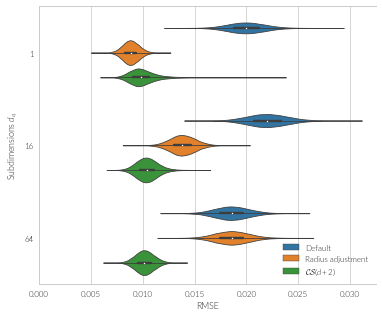

In [69]:
fig = plt.figure(figsize=(textwidth, 2. * row_height))
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(
        'rmse', 'sd', hue='mode',
        data=df.reset_index().query('t > 0.5'),
        hue_order=['default', 'spaopt', 'cosine'],
        orient='horizontal', inner='box', ax=ax, linewidth=0.8)
    ax.set_xlim(left=0.)
    ax.set_xlabel("RMSE")
    ax.set_ylabel("Subdimensions $d_q$")
    ax.legend(
        ax.get_legend_handles_labels()[0],
        ["Default", "Radius adjustment", r"$\mathcal{CS}(d + 2)$"],
        loc='lower right')
sns.despine(fig, top=False)
fig.tight_layout()

In [70]:
save_tight_fig(fig, '../../../phd-thesis/figures/spaopt-repr.pdf')

In [71]:
df_agg = df.groupby(['d', 'n_neurons', 'sd', 'mode', 'seed']).agg(lambda x: np.sqrt(np.mean(np.square(x))))

In [72]:
for n, g in df_agg.groupby(['d', 'n_neurons', 'sd']):
    mode = g.index.get_level_values('mode')
    for a, b in itertools.combinations(mode.unique(), 2):
        d1 = g[mode == a]
        d2 = g[mode == b]
        print(n, a, b, bootstrap_diff_p(d1['rmse'], d2['rmse']))

(64, 200, 1) cosine default 0.0
(64, 200, 1) cosine spaopt 0.0
(64, 200, 1) default spaopt 0.0
(64, 200, 16) cosine default 0.0
(64, 200, 16) cosine spaopt 0.0
(64, 200, 16) default spaopt 0.0
(64, 200, 64) cosine default 0.0
(64, 200, 64) cosine spaopt 0.0
(64, 200, 64) default spaopt 0.9295


The cosine similarity as intercept distribution performs almost as good as spa-opt for subdimensions of 1. It is also only slightly worse than for subdimensions of 1 when increasing the number of subdimensions. This is detrimental for spa-opt, especially with subdimensions equal to the dimensionality (64), the spa-opt methods are not applicable anymore.

Thus, using the cosine similarity distribution is better than spa-opt in almost every aspect. It is applicable to any ratio of subdimesions to dimensions and it doesn't require an optimization step, while only being slightly worse in some cases.

### Dot product

The dot product should also use the cosine similarity distribution. One could think that it should be the sum of two of those distribution given the implementation of the dot product. However, if a vector is compared to itself the two inputs are not independent and it reduces to a single cosine similarity distribution.

In [73]:
class MeanDist(nengo.dists.Distribution):
    def __init__(self, dists):
        super(MeanDist, self).__init__()
        self.dists = dists
        
    def sample(self, n, d=None, rng=np.random):
        return np.sum((dist.sample(n, d, rng) for dist in self.dists), axis=0) / len(self.dists)

In [74]:
class SpaoptProduct(nengo.Network):
    """Computes the element-wise product of two (scaled) unit vectors.
    Requires Scipy.
    """

    def __init__(
            self, n_neurons, dimensions, radius=1.0,
            encoders=nengo.Default, **ens_kwargs):
        super(SpaoptProduct, self).__init__()

        with self:
            distortion = get_distortion(
                nengo.Simulator, nengo.Ensemble(
                    n_neurons, 2, add_to_container=False, **ens_kwargs))
            print('distortion', distortion)
            opt_r = find_optimal_radius(distortion, dimensions, 1)
            scaled_r = radius * opt_r
            
            prod = nengo.networks.Product(n_neurons, dimensions, scaled_r)
            self.A = prod.A
            self.B = prod.B
            self.dimensions = dimensions

            self.output = prod.output

In [75]:
@memory.cache
def get_dot_error(n_neurons, d, mode, seed):
    print(mode, seed)
    seed = int(seed)
    n_neurons = int(n_neurons)
    d = int(d)
    duration = 5.

    rng = np.random.RandomState(seed)

    ctx = nengo.spa.SemanticPointer(d, rng)
    ctx.make_unitary()

    model = nengo.Network(seed=seed + 1)
    with model:
        in_a = nengo.Node(SignalGenerator(duration), size_out=d)
        in_b = nengo.Node(output=ctx.v)

        if mode == 'default':
            prod = nengo.networks.Product(n_neurons, d)
        elif mode == 'spaopt':
            prod = SpaoptProduct(n_neurons, d)
        elif mode == 'cosine':
            with nengo.Config(nengo.Ensemble) as cfg:
                cfg[nengo.Ensemble].eval_points = nengo.dists.CosineSimilarity(d + 2)
                cfg[nengo.Ensemble].intercepts = nengo.dists.CosineSimilarity(d + 2)
                prod = nengo.networks.Product(n_neurons, d)
        else:
            raise ValueError("Invalid mode.")

        result = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        nengo.Connection(in_a, prod.A)
        nengo.Connection(in_b, prod.B)
        nengo.Connection(
            prod.output, result,
            transform=nengo.networks.product.dot_product_transform(d))

        with nengo.Network() as net:
            net.config[nengo.Ensemble].neuron_type = nengo.Direct()
            d_prod = nengo.networks.EnsembleArray(2, d, 2)
            d_result = nengo.Ensemble(1, 1)
        nengo.Connection(in_a, d_prod.input[::2])
        nengo.Connection(in_b, d_prod.input[1::2])
        nengo.Connection(
            d_prod.add_output('dot', lambda x: x[0] * x[1]), d_result,
            transform=[d * [1.]])

        probe = nengo.Probe(result, synapse=None)
        d_probe = nengo.Probe(d_result, synapse=None)

    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(duration)

    return {
        't': sim.trange(),
        'rmse': nengo.utils.numpy.rmse(sim.data[probe], sim.data[d_probe], axis=1),
    }

#### Length calculation

In [76]:
@memory.cache
def get_length_error(n_neurons, d, mode, seed):
    print(mode, seed)
    seed = int(seed)
    n_neurons = int(n_neurons)
    d = int(d)
    duration = 5.

    rng = np.random.RandomState(seed)

    model = nengo.Network(seed=seed + 1)
    with model:
        in_a = nengo.Node(SignalGenerator(duration), size_out=d)

        if mode == 'default':
            prod = nengo.networks.Product(n_neurons, d)
        elif mode == 'spaopt':
            prod = SpaoptProduct(n_neurons, d)
        elif mode == 'cosine':
            with nengo.Config(nengo.Ensemble) as cfg:
                cfg[nengo.Ensemble].eval_points = nengo.dists.CosineSimilarity(d + 2)
                cfg[nengo.Ensemble].intercepts = nengo.dists.CosineSimilarity(d + 2)
                prod = nengo.networks.Product(n_neurons, d)
        else:
            raise ValueError("Invalid mode.")

        result = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        nengo.Connection(in_a, prod.A)
        nengo.Connection(in_a, prod.B)
        nengo.Connection(
            prod.output, result,
            transform=nengo.networks.product.dot_product_transform(d))

        with nengo.Network() as net:
            net.config[nengo.Ensemble].neuron_type = nengo.Direct()
            d_prod = nengo.networks.EnsembleArray(2, d, 2)
            d_result = nengo.Ensemble(1, 1)
        nengo.Connection(in_a, d_prod.input[::2])
        nengo.Connection(in_a, d_prod.input[1::2])
        nengo.Connection(
            d_prod.add_output('dot', lambda x: x[0] * x[1]), d_result,
            transform=[d * [1.]])

        probe = nengo.Probe(result, synapse=None)
        d_probe = nengo.Probe(d_result, synapse=None)

    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(duration)

    return {
        't': sim.trange(),
        'rmse': nengo.utils.numpy.rmse(sim.data[probe], sim.data[d_probe], axis=1),
    }

In [77]:
pspace = (
    Param(n_neurons=200, d=64, mode=['default', 'spaopt', 'cosine']) *
    Param(seed=np.arange(15)))

In [78]:
%time df1 = pd.DataFrame(map_pspace(get_dot_error, pspace))
df1 = df1.groupby(['d', 'n_neurons', 'mode', 'seed']).apply(
    lambda x: pd.DataFrame({'rmse': x['rmse'].values[0]}, index=pd.Index(x['t'].values[0], name='t')))

CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 162 ms


In [79]:
%time df2 = pd.DataFrame(map_pspace(get_length_error, pspace))
df2 = df2.groupby(['d', 'n_neurons', 'mode', 'seed']).apply(
    lambda x: pd.DataFrame({'rmse': x['rmse'].values[0]}, index=pd.Index(x['t'].values[0], name='t')))

default 0
default 1
default 2
default 3
default 4
default 5
default 6
default 7
default 8
default 9
default 10
default 11
default 12
default 13
default 14
spaopt 0
Building finished in 0:00:01.                                                                                                                                                                                                                
distortion 6.969064294654192e-05
spaopt 1
Building finished in 0:00:01.                                                                                                                                                                                                                
distortion 6.697697926934562e-05
spaopt 2
Building finished in 0:00:01.                                                                                                                                                                                                                
distortion 8.60173589714545e-05
spaopt

In [80]:
df = pd.concat((df1, df2), keys=('dot', 'length'), names=['type'])

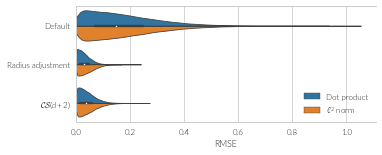

In [81]:
fig = plt.figure(figsize=(textwidth, row_height))
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(
        'rmse', 'mode', hue='type', split=True, order=['default', 'spaopt', 'cosine'],
        data=df.reset_index().query('t > 0.5'),
        orient='horizontal', inner='box', ax=ax, linewidth=0.8)
    ax.set_xlim(left=0.)
    ax.set_xlabel("RMSE")
    ax.set_ylabel("")
    ax.yaxis.set_ticklabels(["Default", "Radius adjustment", r"$\mathcal{CS}(d + 2)$"])
    ax.legend(
        ax.get_legend_handles_labels()[0],
        ["Dot product", r"$\ell^2$ norm"],
        loc='lower right')
sns.despine(fig, top=False)
fig.tight_layout()

In [82]:
save_tight_fig(fig, '../../../phd-thesis/figures/spaopt-dot.pdf')

In [83]:
df_agg = df.groupby(['type', 'd', 'n_neurons', 'mode', 'seed']).agg(lambda x: np.sqrt(np.mean(np.square(x))))

In [84]:
for n, g in df_agg.groupby(['type', 'd', 'n_neurons']):
    mode = g.index.get_level_values('mode')
    for a, b in itertools.combinations(mode.unique(), 2):
        d1 = g[mode == a]
        d2 = g[mode == b]
        print(n, a, b, d1['rmse'].mean() - d2['rmse'].mean(), bootstrap_diff_p(d1['rmse'], d2['rmse']))

('dot', 64, 200) cosine default -0.16491422257108723 0.0
('dot', 64, 200) cosine spaopt 0.011484071195923588 0.0
('dot', 64, 200) default spaopt 0.17639829376701083 0.0
('length', 64, 200) cosine default -0.16322194948081514 0.0
('length', 64, 200) cosine spaopt 0.009081154044687845 0.0
('length', 64, 200) default spaopt 0.172303103525503 0.0


### Circular convolution

For the circular convolution we don't use the `CosineSimilarity` distribution because it does not apply to unitary vectors. For unitary vectors additional constraints apply to the vector components in addition to the normalization of the vector length. In particular, all complex Fourier coefficients are normalized to be of unit length which imposes restrictions on the imaginary and real component. These are not distributed with `CosineSimlarity(d)`, but `CosineSimilarity(2)`. It is not clear what the ideal intercept distribution for `CosineSimilarity(2)` is as it clusters values at -1 and 1 instead around 0. Thus clustering intercepts around zero might still help due to higher firing rates, but it might also degrade the representation as fewer neurons change from on to off in the relevant area.

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/nengo/dists.py:450: RuntimeWarning: divide by zero encountered in power
  (1 - x * x) ** (self.n / 2.0 - 1))


(0.0, 1.6552958555631407)

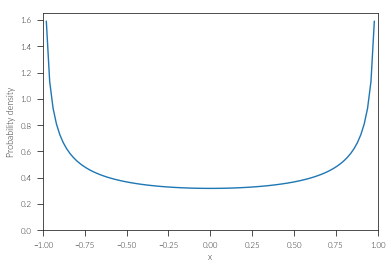

In [85]:
x = np.linspace(-1, 1, 100)
plt.plot(x, nengo.dists.CosineSimilarity(2).pdf(x))
plt.xlabel('x')
plt.ylabel('Probability density')
plt.xlim(-1., 1.)
plt.ylim(bottom=0.)

We would also need to know in advance whether the input vectors are random or unitary to select the appropriate distributions. Overall, it is just easier to use uniform distributions with an adjusted radius.

In [86]:
class SpaoptCircularConvolution(nengo.Network):
    """Compute the circular convolution of two vectors.
    The circular convolution `c` of vectors `a` and `b` is given by
        c[i] = sum_j a[j] * b[i - j]
    where the indices on `b` are assumed to wrap around as required.
    This computation can also be done in the Fourier domain,
        c = DFT^{-1}( DFT(a) * DFT(b) )
    where `DFT` is the Discrete Fourier Transform operator, and
    `DFT^{-1}` is its inverse. This network uses this method.
    Parameters
    ----------
    neurons : Neurons
        A Neurons object, defining both the number of neurons per
        dimension and the neuron model.
    dimensions : int
        The number of dimensions of the input and output vectors.
    invert_a, invert_b : bool
        Whether to reverse the order of elements in either
        the first input (`invert_a`) or the second input (`invert_b`).
        Flipping the second input will make the network perform circular
        correlation instead of circular convolution.
    Examples
    --------
        A = EnsembleArray(nengo.LIF(50), 10)
        B = EnsembleArray(nengo.LIF(50), 10)
        C = EnsembleArray(nengo.LIF(50), 10)
        cconv = nengo.networks.CircularConvolution(nengo.LIF(50), 10)
        nengo.Connection(A.output, cconv.A)
        nengo.Connection(B.output, cconv.B)
        nengo.Connection(cconv.output, C.input)
    Notes
    -----
    The network maps the input vectors `a` and `b` of length N into
    the Fourier domain and aligns them for complex multiplication.
    Letting `F = DFT(a)` and `G = DFT(b)`, this is given by:
        [ F[i].real ]     [ G[i].real ]     [ w[i] ]
        [ F[i].imag ]  *  [ G[i].imag ]  =  [ x[i] ]
        [ F[i].real ]     [ G[i].imag ]     [ y[i] ]
        [ F[i].imag ]     [ G[i].real ]     [ z[i] ]
    where `i` only ranges over the lower half of the spectrum, since
    the upper half of the spectrum is the flipped complex conjugate of
    the lower half, and therefore redundant. The input transforms are
    used to perform the DFT on the inputs and align them correctly for
    complex multiplication.
    The complex product `H = F * G` is then
        H[i] = (w[i] - x[i]) + (y[i] + z[i]) * I
    where `I = sqrt(-1)`. We can perform this addition along with the
    inverse DFT `c = DFT^{-1}(H)` in a single output transform, finding
    only the real part of `c` since the imaginary part is analytically zero.
    """

    def __init__(self, n_neurons, dimensions, invert_a=False, invert_b=False,
                 radius=1, **ens_kwargs):
        super(SpaoptCircularConvolution, self).__init__()
        with self:
            self.dimensions = dimensions
            self.invert_a = invert_a
            self.invert_b = invert_b

            self.A = nengo.Node(size_in=dimensions, label="A")
            self.B = nengo.Node(size_in=dimensions, label="B")
            self.product = SpaoptProduct(n_neurons,
                                   self.transform_out.shape[1],
                                   radius=radius,
                                   label="conv",
                                   **ens_kwargs)
            self.output = nengo.Node(size_in=dimensions, label="output")

            nengo.Connection(self.A, self.product.A,
                             transform=self.transformA, synapse=None)
            nengo.Connection(self.B, self.product.B,
                             transform=self.transformB, synapse=None)
            nengo.Connection(
                self.product.output, self.output, transform=self.transform_out,
                synapse=None)

    @property
    def transformA(self):
        return self._input_transform(self.dimensions, 'A', self.invert_a)

    @property
    def transformB(self):
        return self._input_transform(self.dimensions, 'B', self.invert_b)

    @property
    def transform_out(self):
        dims = self.dimensions
        dims2 = (dims // 2 + 1)
        tr = np.zeros((dims2, 4, dims))
        idft = self.dft_half(dims).conj()

        for i in range(dims2):
            row = idft[i] if i == 0 or 2*i == dims else 2*idft[i]
            tr[i, 0] = row.real
            tr[i, 1] = -row.real
            tr[i, 2] = -row.imag
            tr[i, 3] = -row.imag

        tr = tr.reshape(4*dims2, dims)
        self._remove_imag_rows(tr)
        # scaling is needed since we have 1./sqrt(dims) in DFT
        tr *= np.sqrt(dims)

        return tr.T

    @staticmethod
    def dft_half(n):
        x = np.arange(n)
        w = np.arange(n // 2 + 1)
        return ((1. / np.sqrt(n)) *
                np.exp((-2.j * np.pi / n) * (w[:, None] * x[None, :])))

    @staticmethod
    def _input_transform(dims, align, invert):
        """Create a transform to map the input into the Fourier domain.
        See the class docstring for more details.
        Parameters
        ----------
        dims : int
            Input dimensions.
        align : 'A' or 'B'
            How to align the real and imaginary components; the alignment
            depends on whether we're doing transformA or transformB.
        invert : bool
            Whether to reverse the order of elements.
        """
        if align not in ('A', 'B'):
            raise ValueError("'align' must be either 'A' or 'B'")

        dims2 = 4 * (dims // 2 + 1)
        tr = np.zeros((dims2, dims))
        dft = SpaoptCircularConvolution.dft_half(dims)

        for i in range(dims2):
            row = dft[i // 4] if not invert else dft[i // 4].conj()
            if align == 'A':
                tr[i] = row.real if i % 2 == 0 else row.imag
            else:  # align == 'B'
                tr[i] = row.real if i % 4 == 0 or i % 4 == 3 else row.imag

        SpaoptCircularConvolution._remove_imag_rows(tr)
        return tr.reshape((-1, dims))

    @staticmethod
    def _remove_imag_rows(tr):
        """Throw away imaginary row we don't need (since they're zero)"""
        i = np.arange(tr.shape[0])
        if tr.shape[1] % 2 == 0:
            tr = tr[(i == 0) | (i > 3) & (i < len(i) - 3)]
        else:
            tr = tr[(i == 0) | (i > 3)]

In [87]:
class SumDist(nengo.dists.Distribution):
    def __init__(self, d1, d2):
        super(SumDist, self).__init__()
        self.d1 = d1
        self.d2 = d2
        
    def sample(self, n, d=None, rng=None):
        return (self.d1.sample(n, d, rng=rng) + self.d2.sample(n, d, rng=rng)) / 2.
    
    def __repr__(self):
        return 'SumDist({!r}, {!r})'.format(self.d1, self.d2)
    
    def __hash__(self):
        return hash((self.d1, self.d2))
    
    def __eq__(self, other):
        return isinstance(other, SumDist) and self.d1 == other.d1 and self.d2 == other.d2

In [88]:
@memory.cache
def get_cconv_error(n_neurons, d, mode, seed):
    print(mode, seed)
    seed = int(seed)
    n_neurons = int(n_neurons)
    d = int(d)
    duration = 5.

    rng = np.random.RandomState(seed)

    ctx = nengo.spa.SemanticPointer(d, rng)
    #ctx.make_unitary()

    model = nengo.Network(seed=seed + 1)
    with model:
        in_a = nengo.Node(SignalGenerator(duration), size_out=d)
        in_b = nengo.Node(output=ctx.v)

        if mode == 'default':
            cconv = nengo.networks.CircularConvolution(n_neurons, d)
        elif mode == 'default2':
            cconv = nengo.networks.CircularConvolution(n_neurons, d, input_magnitude=1. / np.sqrt(2.))
        elif mode == 'spaopt':
            cconv = SpaoptCircularConvolution(n_neurons, d)
        elif mode == 'spaopt2':
            cconv = SpaoptCircularConvolution(n_neurons, d, radius=1. / np.sqrt(2.))
        else:
            raise ValueError("Invalid mode.")

        result = nengo.Ensemble(1, d, neuron_type=nengo.Direct())
        nengo.Connection(in_a, cconv.A)
        nengo.Connection(in_b, cconv.B)
        nengo.Connection(cconv.output, result)

        with nengo.Network() as net:
            net.config[nengo.Ensemble].neuron_type = nengo.Direct()
            d_cconv = nengo.networks.CircularConvolution(1, d)
            d_result = nengo.Ensemble(1, d)
        nengo.Connection(in_a, d_cconv.A)
        nengo.Connection(in_b, d_cconv.B)
        nengo.Connection(d_cconv.output, d_result)

        probe = nengo.Probe(result, synapse=None)
        d_probe = nengo.Probe(d_result, synapse=None)

    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(duration)

    return {
        't': sim.trange(),
        'rmse': nengo.utils.numpy.rmse(sim.data[probe], sim.data[d_probe], axis=1),
        'cosine': (np.sum(sim.data[probe] * sim.data[d_probe], axis=1) /
                   np.linalg.norm(sim.data[probe], axis=1) /
                   np.linalg.norm(sim.data[d_probe], axis=1)),
    }

In [89]:
pspace = (
    Param(n_neurons=200, d=64, mode=['default', 'default2', 'spaopt', 'spaopt2']) *
    Param(seed=[1])) #np.arange(15)))

In [90]:
%time df = pd.DataFrame(map_pspace(get_cconv_error, pspace))
df = df.groupby(['d', 'n_neurons', 'mode', 'seed']).apply(
    lambda x: pd.DataFrame({'rmse': x['rmse'].values[0]}, index=pd.Index(x['t'].values[0], name='t')))

CPU times: user 10.9 ms, sys: 2.4 ms, total: 13.3 ms
Wall time: 16.2 ms


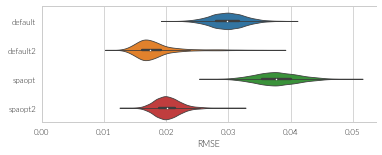

In [91]:

# 50 unitary
fig = plt.figure(figsize=(textwidth, row_height))
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(
        'rmse', 'mode', #order=['default', 'spaopt', 'cosine'],
        data=df.reset_index().query('t > 0.5'),
        orient='horizontal', inner='box', ax=ax, linewidth=0.8)
    ax.set_xlim(left=0.)
    ax.set_xlabel("RMSE")
    ax.set_ylabel("")
    #ax.yaxis.set_ticklabels(["Default", "Radius adjustment", r"$\mathcal{CS}(d + 2)$"])
sns.despine(fig, top=False)
fig.tight_layout()

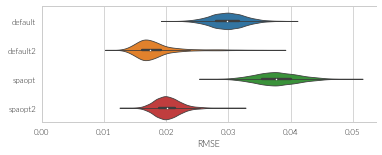

In [92]:

# 200 unitary
fig = plt.figure(figsize=(textwidth, row_height))
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(
        'rmse', 'mode', #order=['default', 'spaopt', 'cosine'],
        data=df.reset_index().query('t > 0.5'),
        orient='horizontal', inner='box', ax=ax, linewidth=0.8)
    ax.set_xlim(left=0.)
    ax.set_xlabel("RMSE")
    ax.set_ylabel("")
    #ax.yaxis.set_ticklabels(["Default", "Radius adjustment", r"$\mathcal{CS}(d + 2)$"])
sns.despine(fig, top=False)
fig.tight_layout()

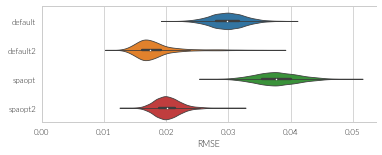

In [93]:

# 50 nonunitary
fig = plt.figure(figsize=(textwidth, row_height))
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(
        'rmse', 'mode', #order=['default', 'spaopt', 'cosine'],
        data=df.reset_index().query('t > 0.5'),
        orient='horizontal', inner='box', ax=ax, linewidth=0.8)
    ax.set_xlim(left=0.)
    ax.set_xlabel("RMSE")
    ax.set_ylabel("")
    #ax.yaxis.set_ticklabels(["Default", "Radius adjustment", r"$\mathcal{CS}(d + 2)$"])
sns.despine(fig, top=False)
fig.tight_layout()

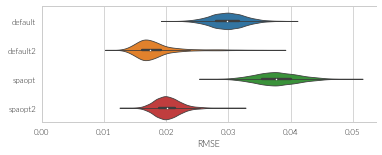

In [94]:

# 200 nonunitary
fig = plt.figure(figsize=(textwidth, row_height))
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(
        'rmse', 'mode', #order=['default', 'spaopt', 'cosine'],
        data=df.reset_index().query('t > 0.5'),
        orient='horizontal', inner='box', ax=ax, linewidth=0.8)
    ax.set_xlim(left=0.)
    ax.set_xlabel("RMSE")
    ax.set_ylabel("")
    #ax.yaxis.set_ticklabels(["Default", "Radius adjustment", r"$\mathcal{CS}(d + 2)$"])
sns.despine(fig, top=False)
fig.tight_layout()

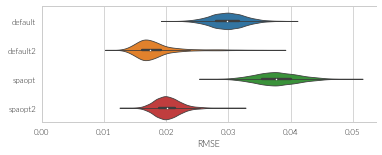

In [95]:

# 50 nonnonunitary
fig = plt.figure(figsize=(textwidth, row_height))
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(
        'rmse', 'mode', #order=['default', 'spaopt', 'cosine'],
        data=df.reset_index().query('t > 0.5'),
        orient='horizontal', inner='box', ax=ax, linewidth=0.8)
    ax.set_xlim(left=0.)
    ax.set_xlabel("RMSE")
    ax.set_ylabel("")
    #ax.yaxis.set_ticklabels(["Default", "Radius adjustment", r"$\mathcal{CS}(d + 2)$"])
sns.despine(fig, top=False)
fig.tight_layout()

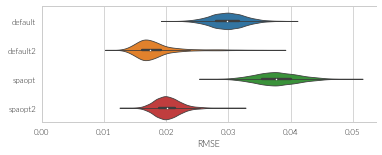

In [96]:

# 200 nonnonunitary
fig = plt.figure(figsize=(textwidth, row_height))
with sns.axes_style('whitegrid'):
    ax = fig.add_subplot(1, 1, 1)
    sns.violinplot(
        'rmse', 'mode', #order=['default', 'spaopt', 'cosine'],
        data=df.reset_index().query('t > 0.5'),
        orient='horizontal', inner='box', ax=ax, linewidth=0.8)
    ax.set_xlim(left=0.)
    ax.set_xlabel("RMSE")
    ax.set_ylabel("")
    #ax.yaxis.set_ticklabels(["Default", "Radius adjustment", r"$\mathcal{CS}(d + 2)$"])
sns.despine(fig, top=False)
fig.tight_layout()

# Summary

* The cosine similarity improves the accuracy of ensembles with spiking neurons with more than 1 dimension. This seems to hold true in general.
* For rate neurons the uniform distribution is better, if one adjusts the solver regularization to account for the non-existent noise.
* The cosine similarity gives a scaling of the noise error with $O(d^{3/4})$ instead of $O(d)$.
* Some non-uniform intercept distributions might be even better than the cosine similarity in some circumstances, but these will not be better than the uniform distribution in all cases.
  * One example is the flipped subvector length distribution. It is good for high-dimensional ensembles, but not for low-dimensional ensembles (especially when computing a non-linear functions.).
* The non-uniform intercept distributions can introduce a bias into the representational space in the sense that the error in certain areas might be lower than in others (it is not uniformly distributed).
* We can use the cosine similarity distribution for intercepts and evaluation points to achieve an accuracy at the level of spa-opt without slow optimization step and generalization over any number of subdimensions.

# Acknowledgements

I would like to thank Aaron R. Voelker for inspiring this research and Terrence C. Stewart for performing [first experiments with non-uniform intercept distributions](https://github.com/nengo/nengo_extras/issues/34).